# Analyzing High School Test Score Data

![test score](files/Data/high_schools/test_score.jpg)



-------------------------------------


## *Table of Contents*
* [1. Introduction](#1)
* [2. Importing the Data](#2)
    * [2.1 Exploring the SAT Data](#2.1)
    * [2.2 Reading in the Survey Data](#2.2)
    * [2.3 Cleaning Up the Surveys](#2.3)    
* [3. Preparing Datasets for Merging](#3)
    * [3.1 Convert Columns to Numeric](#3.1)
    * [3.2 Parsing Geographic Coordinates for Schools](#3.2)
* [4. Combining the Data](#4)
    * [4.1 Condensing the Class Size Data Set](#4.1)
    * [4.2 Computing Average Class Sizes](#4.2)
    * [4.3 Condensing the Demographics Data Set](#4.3)
    * [4.4 Condensing the Graduation Data Set](#4.4)
    * [4.5 Converting AP Test Scores](#4.5)
    * [4.6 Performing the Left Joins](#4.6)
    * [4.7 Performing the Inner Joins](#4.7)
* [5. Filling in Missing Values](#5)
* [6. Testing the Dataset with Descriptive Statistics](#6)
    * [6.1 Exploring SAT-score and Survey Answer Correlations](#6.1)
    * [6.2 Exploring Races and SAT-Scores](#6.2)
    * [6.3 Explore Gender and SAT-Scores](#6.3)
* [7. Conclusion](#7)
* [8. Descriptive Statistics](#8)

-------------------------------------
<br>
<br>

## <a name="1"></a> 1. Introduction
-------------------------------
Around the world, it is common for a country to have a nation-wide standardized test for yearly evaluating the students in all High Schools. 

This is no different, if we take a look at the U.S. where the *Scholastic Aptitude Test* (SAT) is performed.  For a brief bit of background, the SAT is a test that high school seniors in the U.S. take every year. The [SAT](https://en.wikipedia.org/wiki/SAT) has three sections, each of which is worth a maximum of **800 points**. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. The datasets which we will work with in this project, are the following:
* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/2010-2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school (these data exists only in two `txt` files)

<br>

**The goal of this project:**
* Read in all the different data sources
* Prepare the datasets for merging
* Combine all the data into a coherent dataset
* Generate descriptive statistics to demonstrate the flawless nature of the dataset
<br>
<br>

## <a name="2"></a> 2. Importing the Data
-----------------
As presented above, we have **6 different data sources** in the form of `CSV` files and **2 survey datasets** as `txt` files. `survey_all.txt` and `survey_d75.txt` are in more complicated formats than the other files. For now, we'll focus on reading in the `CSV` files only, and then explore them.

One quick approach to import the data of these CSVs would be to `loop` through each file and then place each dataset in a ***dictionary***.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import re
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {} #The dictionary which will contain the data of each CSV file

for file in data_files:
    raw_data = pd.read_csv("Data/high_schools/" + str(file)) #Reads the path "data/[filename]"
    file_name = file.split('.')
    df_name = file_name[0] #Uses the name of the file as a reference in the dictionary
    data[df_name] = raw_data

### <a name="2.1"></a> 2.1 Exploring the SAT Data
What we're mainly interested in is the SAT data set, which corresponds to the dictionary key `sat_results`. This data set contains the SAT scores for each high school in New York City. We eventually want to correlate selected information from this data set with information in the other data sets.

Let's explore `sat_results` to see what we can discover. Exploring the dataframe will help us understand the structure of the data, and make it easier for us to analyze it.

In [2]:
results = data['sat_results']
results.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


We can make a few observations based on this output:

* The DBN appears to be a unique ID for each school.
* We can tell from the first few rows of names that we only have data about high schools.
* There's only a single row for each high school, so each DBN is unique in the SAT data.
* We may eventually want to combine the three columns that contain SAT scores -- `SAT Critical Reading Avg.`, `Score SAT Math Avg. Score`, and `SAT Writing Avg. Score` -- into a single column to make the scores easier to analyze.

Given these observations, let's explore the other data sets to see if we can gain any insight into how to combine them.

In [3]:
for index, value in data.items():
    df = value
    print(df.head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

### <a name="2.2"></a> 2.2 Reading in the Survey Data
We can make some observations based on the first few rows of each one.

* Each data set appears to either have a `DBN` column, or the information we need to create one. That means we can use a `DBN` column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical DBNs, then group all of their columns together in a single data set.
* Some fields look interesting for mapping -- particularly `Location 1`, which contains coordinates inside a larger string.
* Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate `DBN` values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each data set. If we don't do this, we'll run into problems when we combine the data sets, because we might be merging two rows in one data set with one row in another data set.

<br>

Before we proceed with the merge, we should make sure we have all of the data we want to unify. We mentioned the survey data earlier (`survey_all.txt` and `survey_d75.txt`), but we didn't read those files in because they're in a slightly more complex format.

<br>

The files are tab delimited and encoded with **Windows-1252** encoding. An encoding defines how a computer stores the contents of a file in binary. The most common encodings are **UTF-8** and **ASCII**. Windows-1252 is rarely used, and can cause errors if we read such a file in without specifying the encoding.

In [4]:
all_survey = pd.read_csv('Data/high_schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('Data/high_schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=True)
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Columns: 2773 entries, N_p to t_q9_5
dtypes: float64(2762), int64(6), object(5)
memory usage: 36.0+ MB


In [5]:
survey.head()

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,M034,8.2,5.9,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,M063,7.9,NaN,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


### <a name="2.3"></a> 2.3 Cleaning Up the Surveys
There are two immediate facts that we can see in the data:

* There are over `2000` columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.
* The survey data has a `dbn` column that we'll want to convert to uppercase (`DBN`). The conversion will make the column name consistent with the other data sets.

First, we'll need filter the columns to remove the ones we don't need. Luckily, there's a data dictionary at the original data download location. The dictionary tells us what each column represents. Based on our knowledge of the problem and the analysis we're trying to do, we can use the data dictionary to determine which columns to use.

Based on the dictionary, it looks like these are the relevant columns:
```python
["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
```
These columns will give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It will also give us the DBN, which allows us to uniquely identify the school.

In [6]:
survey["DBN"] = survey["dbn"]
survey = survey[["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]]
data['survey'] = survey
data['survey'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Data columns (total 23 columns):
DBN           1702 non-null object
rr_s          1041 non-null float64
rr_t          1702 non-null int64
rr_p          1702 non-null int64
N_s           1036 non-null float64
N_t           1700 non-null float64
N_p           1696 non-null float64
saf_p_11      1696 non-null float64
com_p_11      1696 non-null float64
eng_p_11      1696 non-null float64
aca_p_11      1696 non-null float64
saf_t_11      1700 non-null float64
com_t_11      1700 non-null float64
eng_t_11      1700 non-null float64
aca_t_11      1700 non-null float64
saf_s_11      1036 non-null float64
com_s_11      1036 non-null float64
eng_s_11      1036 non-null float64
aca_s_11      1036 non-null float64
saf_tot_11    1702 non-null float64
com_tot_11    1702 non-null float64
eng_tot_11    1702 non-null float64
aca_tot_11    1702 non-null float64
dtypes: float64(20), int64(2), object(1)
memory usage: 319.1+ KB


<br>

## <a name="3"></a> 3. Preparing Datasets for Merging
-----------------
When we explored all of the data sets, we noticed that some of them, like `class_size` don't have a DBN column. `hs_directory` does have a dbn column, though, so we can just rename it.

However, class_size doesn't appear to have the column at all.

In [7]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


With a closer inspection of the datasets, we can tell that the `DBN` in the `sat_results` data is just a combination of the `CSD` and `SCHOOL CODE` columns in the `class_size` data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the `CSD` if the `CSD` is less than two digits long.

We can accomplish this using the pandas **pandas.DataFrame.apply()** method, along with a custom function that:

* Takes in a number.
* Converts the number to a string using the str() function.
* Check the length of the string using the len() function.
* If the string is two digits long, returns the string.
* If the string is one digit long, adds a 0 to the front of the string, then returns it.

In [10]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def padding(row):
    string_rep = str(row)
    if len(string_rep) > 1:
        return string_rep
    else:
        return string_rep.zfill(2)

data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(padding)
data['class_size']["DBN"] = data['class_size']["padded_csd"] + data['class_size']["SCHOOL CODE"]
data['class_size']["DBN"].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

### <a name="3.1"></a> 3.1 Convert Columns to Numeric
Now we're almost ready to combine our data sets. Before we do, let's take some time to calculate variables that will be useful in our analysis. We've already discussed one such variable -- a column that totals up the SAT scores for the different sections of the exam. This will make it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

Before we can generate this column, we'll need to convert the `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns in the sat_results data set from the object (string) data type to a numeric data type. We can use the **pandas.to_numeric()** method for the conversion. If we don't convert the values, we won't be able to add the columns together.

It's important to pass the keyword argument `errors="coerce"` when we call `pandas.to_numeric()`, so that pandas treats any invalid strings it can't convert to numbers as missing values instead.

After we perform the conversion, we can use the addition operator (`+`) to add all three columns together.

In [8]:
data['sat_results']['SAT Math Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Math Avg. Score'], errors='coerce')
data['sat_results']['SAT Critical Reading Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Critical Reading Avg. Score'], errors='coerce')
data['sat_results']['SAT Writing Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Writing Avg. Score'], errors='coerce')

data['sat_results']['sat_score'] = data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Writing Avg. Score']

data['sat_results']['sat_score'].head()

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

### <a name="3.2"></a> 3.2 Parsing Geographic Coordinates for Schools
Next, we'll want to parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field `Location 1` in the `hs_directory` data set.

Let's take a look at the first few rows:

In [9]:
data["hs_directory"]['Location 1'].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160 20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

As you can see, this field contains a lot of information we don't need. We want to extract the coordinates, which are in parentheses at the end of the field. More specifically, we want to extract the latitude, `40.8276026690005`, and the longitude, `-73.90447525699966`. Taken together, latitude and longitude make up a pair of coordinates that allows us to pinpoint any location on Earth.

<br>

We can do the extraction with a regular expression. The following expression will pull out everything inside the parentheses:
```python
import re
re.findall("\(.+\)", "1110 Boston Road\nBronx, NY 10456\n(40.8276026690005, -73.90447525699966)")
```
This command will return (`40.8276026690005`, `-73.90447525699966`). We'll need to process this result further using the string methods `split()` and `replace()` methods to extract each coordinate.

In [11]:
def get_lat(row):
    coords = re.findall("\(.+\)", row)
    coords = coords[0].replace('(', '')
    coords = coords.replace(')', '')
    coords = coords.split(',')
    return coords[0]
    
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(get_lat)
data['hs_directory']['lat'].head()

0     40.67029890700047
1      40.8276026690005
2    40.842414068000494
3     40.71067947100045
4    40.718810094000446
Name: lat, dtype: object

we have now parsed the **latitude** from the `Location 1` column. Now we'll just need to do the same for the **longitude**.

Once we have both coordinates, we'll need to convert them to numeric values. We can use the `pandas.to_numeric()` function to convert them from strings to numbers.

In [12]:
def get_lon(row):
    coords = re.findall("\(.+\)", row)
    coords = coords[0].replace('(', '')
    coords = coords.replace(')', '')
    coords = coords.split(',')
    return coords[1]
    
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(get_lon)
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
print(data['hs_directory'][['lon', 'lat']].head())

         lon        lat
0 -73.961648  40.670299
1 -73.904475  40.827603
2 -73.916162  40.842414
3 -74.000807  40.710679
4 -73.806500  40.718810


## <a name="4"></a> 4. Combining the Data
-----------------
The first thing we'll need to do in preparation for the merge is condense some of the data sets. In some of the previous steps, we noticed that the values in the `DBN` column were unique in the `sat_results` data set. Other data sets like `class_size` had duplicate `DBN` values, however.

We'll need to condense these data sets so that each value in the `DBN` column is unique. If not, we'll run into issues when it comes time to combine the data sets.


While the main data set we want to analyze, `sat_results`, has unique `DBN` values for every high school in New York City, other data sets aren't as clean. A single row in the `sat_results` data set may match multiple rows in the `class_size` data set, for example. This situation will create problems, because we don't know which of the multiple entries in the `class_size` data set we should combine with the single matching entry in `sat_results`.

To resolve this issue, we'll condense the `class_size`, `graduation`, and `demographics` data sets so that each `DBN` is unique.

### <a name="4.1"></a> 4.1 Condensing the Class Size Data Set
The first data set that we'll condense is `class_size`. The first few rows of `class_size` look like this:

In [13]:
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


As you can see, the first few rows all pertain to the same school, which is why the `DBN` appears more than once. It looks like each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`.

If we look at the unique values for GRADE, we get the following:

In [16]:
data["class_size"]['GRADE '].value_counts()

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64

Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the `GRADE` column is `09-12`.

If we look at the unique values for PROGRAM TYPE, we get the following:

In [17]:
data["class_size"]['PROGRAM TYPE'].value_counts()

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64

Each school can have multiple program types. Because `GEN ED` is the largest category by far, let's only select rows where `PROGRAM TYPE` is `GEN ED`.

In [18]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


### <a name="4.2"></a> 4.2 Computing Average Class Sizes
As we saw when we displayed class_size on the last screen, DBN still isn't completely unique. This is due to the `CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` columns.

`CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` seem to pertain to different kinds of classes. For example, here are the unique values for `CORE SUBJECT (MS CORE and 9-12 ONLY)`:

In [19]:
class_size['CORE SUBJECT (MS CORE and 9-12 ONLY)'].value_counts()

ENGLISH           1977
SCIENCE           1636
SOCIAL STUDIES    1453
MATH              1447
Name: CORE SUBJECT (MS CORE and 9-12 ONLY), dtype: int64

This column only seems to include certain subjects. We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This will give us unique DBN values, while also incorporating as much data as possible into the average.

Fortunately, we can use the **pandas.DataFrame.groupby()** method to help us with this. The DataFrame.groupby() method will split a dataframe up into unique groups, based on a given column. We can then use the **agg()** method on the resulting `pandas.core.groupby` object to find the mean of each column.

<br>

After we group a dataframe and aggregate data based on it, the column we performed the grouping on (in this case `DBN`) will become the index, and will no longer appear as a column in the data itself. To undo this change and keep DBN as a column, we'll need to use `pandas.DataFrame.reset_index()`. This method will reset the index to a list of integers and make DBN a column again.

In [20]:
class_size = class_size.groupby('DBN')
class_size = class_size.agg(numpy.mean)
class_size = class_size.reset_index()
data['class_size'] = class_size
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### <a name="4.3"></a> 4.3 Condensing the Demographics Data Set
Now that we've finished condensing `class_size`, let's condense `demographics`. The first few rows look like this:

In [21]:
print(data['demographics'].head())

      DBN                       Name  schoolyear fl_percent  frl_percent  \
0  01M015  P.S. 015 ROBERTO CLEMENTE    20052006       89.4          NaN   
1  01M015  P.S. 015 ROBERTO CLEMENTE    20062007       89.4          NaN   
2  01M015  P.S. 015 ROBERTO CLEMENTE    20072008       89.4          NaN   
3  01M015  P.S. 015 ROBERTO CLEMENTE    20082009       89.4          NaN   
4  01M015  P.S. 015 ROBERTO CLEMENTE    20092010                    96.5   

   total_enrollment prek   k grade1 grade2    ...     black_num black_per  \
0               281   15  36     40     33    ...            74      26.3   
1               243   15  29     39     38    ...            68      28.0   
2               261   18  43     39     36    ...            77      29.5   
3               252   17  37     44     32    ...            75      29.8   
4               208   16  40     28     32    ...            67      32.2   

  hispanic_num hispanic_per white_num white_per male_num male_per female_num  \


In this case, the only column that prevents a given `DBN` from being unique is `schoolyear`. We only want to select rows where `schoolyear` is `20112012`. This will give us the most recent year of data, and also match our SAT results data.

In [24]:
DM = data['demographics']
DM = DM[DM['schoolyear']==20112012]
data['demographics'] = DM
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### <a name="4.4"></a> 4.4 Condensing the Graduation Data Set
Finally, we'll need to condense the graduation data set. Here are the first few rows:

In [23]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


The `Demographic` and `Cohort` columns are what prevent `DBN` from being unique in the `graduation` data. A `Cohort` appears to refer to the year the data represents, and the `Demographic` appears to refer to a specific demographic group. In this case, we want to pick data from the most recent `Cohort` available, which is `2006`. We also want data from the full cohort, so we'll only pick rows where `Demographic` is `Total Cohort`.

In [22]:
GD = data['graduation']
GD = GD[GD['Cohort'] == '2006']
GD = GD[GD['Demographic'] == 'Total Cohort']
data['graduation'] = GD
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


### <a name="4.5"></a> 4.5 Converting AP Test Scores
We're almost ready to combine all of the data sets. The only remaining thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a `1` to `5` scale; `3` or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are much more rare in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the `ap_2010` data set to numeric values first.

There are three columns we'll need to convert:
* AP Test Takers
* Total Exams Taken
* Number of Exams with scores 3, 4 or 5

In [25]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for i in cols:
    data['ap_2010'][i] = pd.to_numeric(data['ap_2010'][i], errors='coerce')
    print('-----')
    print(i)
    print(data['ap_2010'][i].dtypes)

-----
AP Test Takers 
float64
-----
Total Exams Taken
float64
-----
Number of Exams with scores 3 4 or 5
float64


### <a name="4.6"></a> 4.6 Performing the Left Joins
Both the `ap_2010` and the graduation data sets have many missing `DBN` values, so we'll use a `left` join when we merge the `sat_results` data set with them. Because we're using a `left` join, our final dataframe will have all of the same `DBN` values as the original `sat_results` dataframe.

We'll need to use the pandas `df.merge()` method to merge dataframes. The "left" dataframe is the one we call the method on, and the "right" dataframe is the one we pass into `df.merge()`.

Because we're using the `DBN` column to join the dataframes, we'll need to specify the keyword argument `on="DBN"` when calling `pandas.DataFrame.merge()`.

First, we'll assign `data["sat_results"]` to the variable `combined`. Then, we'll merge all of the other dataframes with combined. When we're finished, combined will have all of the columns from all of the data sets.

In [26]:
combined = data["sat_results"]
combined = combined.merge(data['ap_2010'], how='left', on='DBN')
combined = combined.merge(data['graduation'], how='left', on='DBN')
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


### <a name="4.7"></a> 4.7 Performing the Inner Joins
Now that we've performed the `left` joins, we still have to merge `class_size`, `demographics`, `survey`, and `hs_directory` into `combined`. Because these files contain information that's more valuable to our analysis and also have fewer missing `DBN` values, we'll use the `inner` join type.

In [27]:
combined = combined.merge(data['class_size'], how='inner', on='DBN')
combined = combined.merge(data['demographics'], how='inner', on='DBN')
combined = combined.merge(data['survey'], how='inner', on='DBN')
combined = combined.merge(data['hs_directory'], how='inner', on='DBN')
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426


## <a name="5"></a> 5. Filling in Missing Values
---------------
You may have noticed that the `inner` joins resulted in `116` fewer rows in `sat_results`. This is because pandas couldn't find the `DBN` values that existed in `sat_results` in the other data sets. While this is worth investigating, we're currently looking for high-level correlations, so we don't need to dive into which DBNs are missing.

You may also have noticed that we now have many columns with null (`NaN`) values. This is because we chose to do `left` joins, where some columns may not have had data. The data set also had some missing values to begin with. If we hadn't performed a `left` join, all of the rows with missing data would have been lost in the merge process, which wouldn't have left us with many high schools in our data set.

There are several ways to handle missing data, and we'll cover them in more detail later on. For now, we'll just fill in the missing values with the overall mean for the column.

In [28]:
means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)
combined.isna().sum()

DBN                                     0
SCHOOL NAME                             0
Num of SAT Test Takers                  0
SAT Critical Reading Avg. Score         0
SAT Math Avg. Score                     0
SAT Writing Avg. Score                  0
sat_score                               0
SchoolName                              0
AP Test Takers                          0
Total Exams Taken                       0
Number of Exams with scores 3 4 or 5    0
Demographic                             0
School Name                             0
Cohort                                  0
Total Cohort                            0
Total Grads - n                         0
Total Grads - % of cohort               0
Total Regents - n                       0
Total Regents - % of cohort             0
Total Regents - % of grads              0
Advanced Regents - n                    0
Advanced Regents - % of cohort          0
Advanced Regents - % of grads           0
Regents w/o Advanced - n          

## <a name="6"></a> 6. Testing the Dataset with Descriptive Statistics
----------------
We've finished cleaning and combining our data! We now have a clean data set on which we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

The school district is just the first two characters of the `DBN`. We can apply a function over the `DBN` column of `combined` that pulls out the first two letters.

In [29]:
def two_char(row):
    school_dist = str(row)
    school_dist = school_dist[0:2]
    return school_dist

combined['school_dist'] = combined['DBN'].apply(two_char)
combined['school_dist'].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

### <a name="6.1"></a> 6.1 Exploring SAT-score and Survey Answer Correlations
The first thing we'll do is find any correlations between any of the columns and sat_score. This will help us determine which columns might be interesting to plot out or investigate further.

Correlations tell us how closely related two columns are. We'll be using the r value, also called Pearson's correlation coefficient, which measures how closely two sequences of numbers are correlated.

We will only be touching lightly on correlations without investigating any signifiance. In general, r values above `.25` or below `-.25` are enough to qualify a correlation as interesting. An r value isn't perfect, and doesn't indicate that there's a correlation -- just the possiblity of one.

Let's take a closer look at how the survey results correlates with the SAT-score.

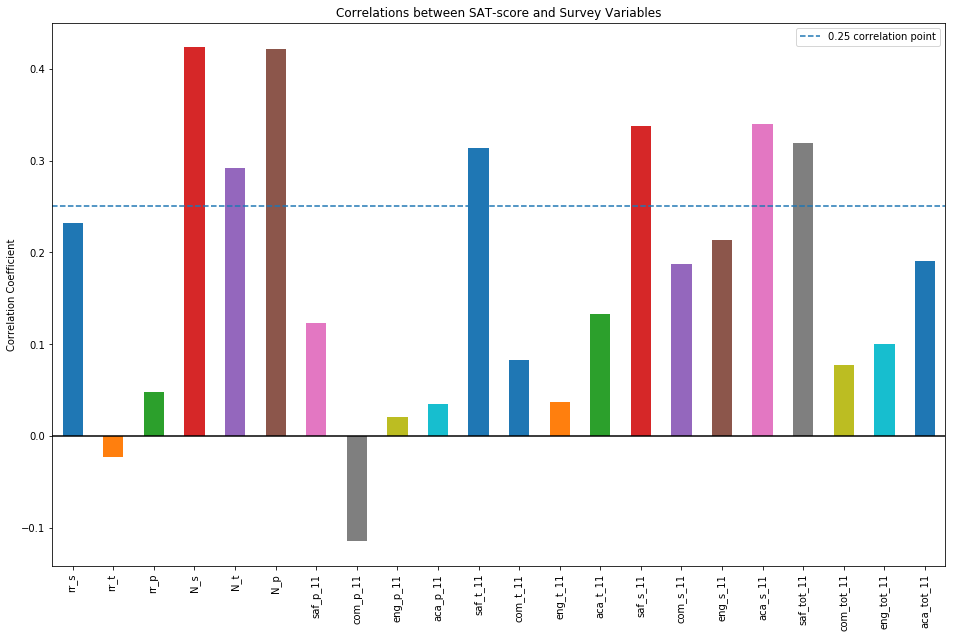

In [31]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations = correlations.loc[["rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]]
correlations.plot.bar(title='Correlations between SAT-score and Survey Variables', figsize=(16,10))
the_line = plt.axhline(0.25, label='0.25 correlation point', linestyle='--')
plt.axhline(0, color='black')
plt.ylabel('Correlation Coefficient')
plt.legend(handles=[the_line])
plt.show()

The bar plot outlines some very interesting patterns. First and foremost, there is not any noteworthy negative correlations. However, some positive correlations can be noticed:
* Number of student respondents, teacher respondents and parent respondents (`N_s`, `N_t` and `N_p`)
* Safety and Respect score based on teacher responses, student responses and total score (`saf_t_11`, `saf_s_11` and `saf_tot_11`)
* Academic expectations score based on student responses (`aca_s_11`)

A **higher number of survey respondents** is correlated with a higher SAT-score. This observation is a bit challenging to explain, but it may suggest that a community with a higher response reflects a general greater engagement attitude in various school tasks.

If we move to the next interesting observation, we will see that a **higher reported safety and respect score** from both teachers and students correlates with a higher SAT-score. This strongly suggest that an environment where safety and respect are prioritized and maintained, leads to students accomplishing better SAT-scores.

Finally, a higher degree of **academic expectation score** is also correlated with a higher SAT-score. It may not be surprising, as this indicates when students have a higher expectations from themselves, it also results in greater SAT-scores. Interestingly, the academic expectations score from parents does not seem to have any noteworthy effect.

### <a name="6.2"></a> 6.2 Exploring Races and SAT-Scores
Let's utilize other parts of the merged dataset by turning our focus on the demographics. More specifically, we can investigate if there is any correlation between the races and obtaining a high SAT-score. 

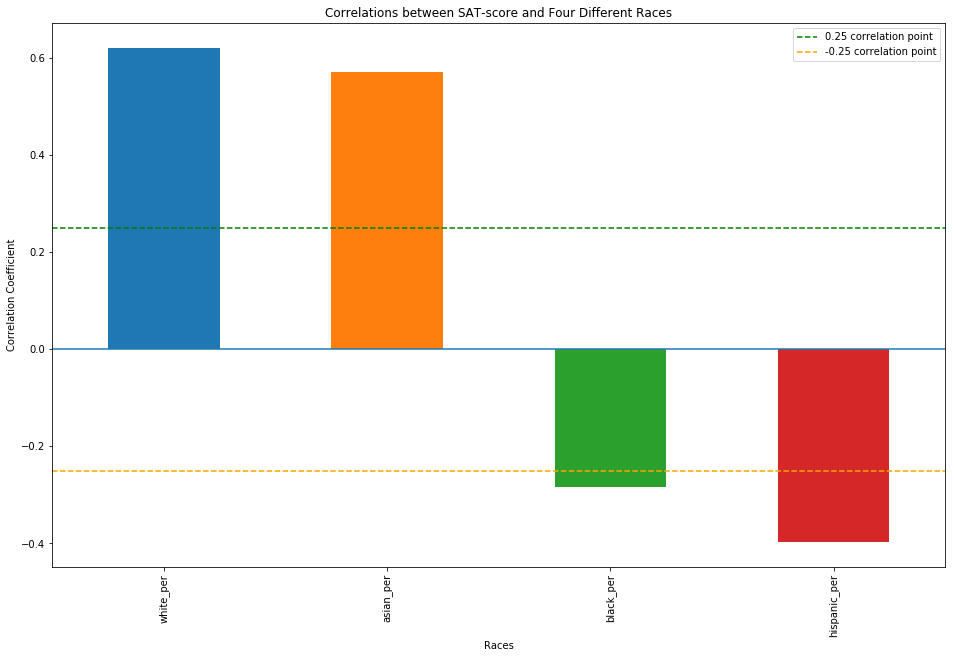

In [30]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations = correlations.loc[["white_per", "asian_per", "black_per", "hispanic_per"]]
correlations.plot.bar(title='Correlations between SAT-score and Four Different Races', figsize=(16,10))
the_line1 = plt.axhline(0.25, label='0.25 correlation point', linestyle='--', color='green')
the_line2 = plt.axhline(-0.25, label='-0.25 correlation point', linestyle='--', color='orange')
plt.axhline(0)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Races')
plt.legend(handles=[the_line1, the_line2])
plt.show()

Surprisingly, the bar plot illustrates a strong correlation for each race and the SAT-score:

* Schools with a higher percentage of white and asian students generally have a higher SAT-score
* schools with a higher percentage of black and hispanic students generally have a lower SAT-score

It can be difficult to interpret this result as there would be numerous factors behind this pattern. I will suggest digging into the Hispanic correlation by creating a scatter-plot.

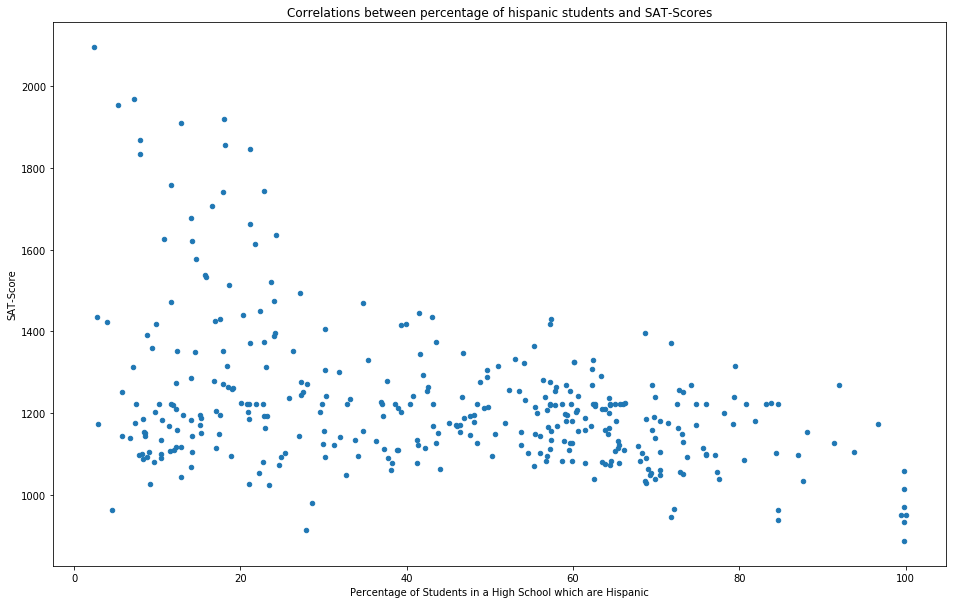

In [33]:
combined.plot.scatter(x='hispanic_per', y='sat_score', figsize=(16,10), title='Correlations between percentage of hispanic students and SAT-Scores')
plt.ylabel('SAT-Score')
plt.xlabel('Percentage of Students in a High School which are Hispanic')
plt.show()

The scatter-plot above supports the pattern we observed in the previous bar-plot. The plot indicate a trend that the lower the percentage of hispanic students, the higher the SAT-Score.

### <a name="6.3"></a> 6.3 Explore Gender and SAT-Scores
Let's wrap up this small analytics section by investigating the correlations between the genders and the SAT-Score.

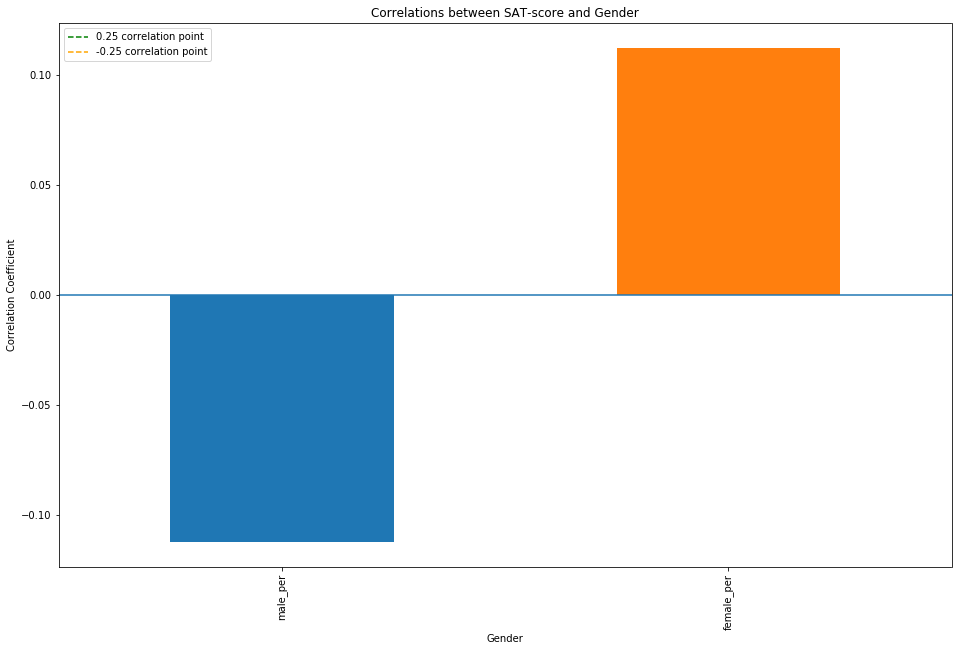

In [32]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations = correlations.loc[["male_per", "female_per"]]
correlations.plot.bar(title='Correlations between SAT-score and Gender', figsize=(16,10))
plt.axhline(0)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Gender')
plt.legend(handles=[the_line1, the_line2])
plt.show()

There is a slight difference between the genders. Females tend to have a higher SAT-score and vice versa. However, it is important to notice that the correlations are only 0.11 for both genders which indicates a weak correlation. Thus, this suggests that it does not make a difference for a high school to have more of one gender.

## <a name="7"></a> 7. Conclusion
The goals of this project were to demonstrate process of importing several datasets, prepare the datasets for merging, merge the data sets and perform descriptive statistics with the combined data. While the descriptive statistics showed some interesting findings, the project was only to demonstrate skills in the data cleaning and wrangling process.